# SPOTIFY IMPORT

In [1]:
!pip install spotipy

In [2]:
! pip install lime

In [3]:
%matplotlib inline

In [4]:
#Mount Google Drive
# link to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys

PROJECT_ROOT = '/content/drive/My Drive/Colab Notebooks/Project/Hit-Song-Prediction/'
sys.path.append(PROJECT_ROOT)

In [6]:
from SpotifyConnection import get_spotify_connection
import Playlist as PL
from DataProcessing import normalize_dataframe, DataInformation, SpotifyTracksDataset, normalize_data_by_type, normalize_data

In [7]:
sp = get_spotify_connection()

# PyTorch Import

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# Other Imports

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
import random

def seed_torch(seed=0):
  random.seed(seed)

  np.random.seed(seed)
  np.random.RandomState(seed)

  torch.manual_seed(seed) 
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) #seed all gpus    
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.enabled = False  
  torch.backends.cudnn.benchmark = False

seed_torch(0)

# Load Data

In [12]:
DataInformation.list()

['duration',
 'key',
 'mode',
 'time_signature',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'valence',
 'tempo',
 'artist_popularity',
 'popularity']

In [13]:
pl = PL.load_playlist(PROJECT_ROOT + "playlist_2sRZldX6n9oaII70OoO3zB")
df = pl.get_playlist_df(cols=DataInformation.list())
cols_to_normalize = DataInformation.Feature.list()
cols_to_normalize.remove('artist_popularity')
normalized_df = normalize_dataframe(df, cols_to_normalize)

Loaded playlist from file: /content/drive/My Drive/Colab Notebooks/Project/Hit-Song-Prediction/playlist_2sRZldX6n9oaII70OoO3zB


In [14]:
normalized_df.head()

,duration,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,artist_popularity,popularity
0,0.068542,0.000000,1.0,0.8,0.111444,0.805471,0.594832,0.0,0.145511,0.858757,0.079468,0.409,0.616788,98.0,76
1,0.066175,0.909091,0.0,0.8,0.344376,0.701114,0.714176,0.0,0.083591,0.896666,0.373404,0.615,0.627561,90.0,63
2,0.067781,0.727273,0.0,1.0,0.241966,0.493414,0.366173,0.0,0.108359,0.787748,0.056489,0.161,0.311547,83.0,75
3,0.055939,0.727273,1.0,1.0,0.127508,0.597771,0.653000,0.0,0.042931,0.865515,0.356383,0.691,0.569657,77.0,28
4,0.070991,0.090909,1.0,0.8,0.035641,0.834853,0.734234,0.0,0.312693,0.874820,0.065213,0.393,0.447603,84.0,75


In [15]:
features = DataInformation.Feature.list()
features.remove(DataInformation.Feature.KEY.value)
features.remove(DataInformation.Feature.MODE.value)
features.remove(DataInformation.Feature.TIME_SIGNATURE.value)

target = DataInformation.TARGET

cols = features + [target]

df = pl.get_playlist_df()

df.duration = df.duration / 1000
df.duration = normalize_data_by_type(df.duration, DataInformation.NormalizationType.STD_CLAMP)
df.tempo = normalize_data_by_type(df.tempo, DataInformation.NormalizationType.DEFAULT)
df.loudness = normalize_data_by_type(df.loudness, DataInformation.NormalizationType.DEFAULT)
df.artist_popularity = normalize_data(df.loudness, data_min=0, data_max=1)


df.head()

,id,name,popularity,duration,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,artist_popularity,release_date,explicit
0,0q75NwOoFiARAVp4EXU4Bs,Love Galore (feat. Travis Scott),76,0.634485,0,1,4,0.1110,0.795,0.594,0.0,0.1620,0.858757,0.0747,0.409,0.616788,0.858757,2017-06-09,True
1,593W4qZOwwdqF6YnimJjL6,Doves In The Wind (feat. Kendrick Lamar),63,0.600865,10,0,4,0.3430,0.692,0.713,0.0,0.1020,0.896666,0.3510,0.615,0.627561,0.896666,2017-06-09,True
2,6gU9OKjOE7ghfEd55oRO57,The Weekend,75,0.623675,8,0,5,0.2410,0.487,0.366,0.0,0.1260,0.787748,0.0531,0.161,0.311547,0.787748,2017-06-09,True
3,23wcL7jlwSLVZ54V1qO7oO,Plot Twist,28,0.455525,8,1,5,0.1270,0.590,0.652,0.0,0.0626,0.865515,0.3350,0.691,0.569657,0.865515,2017-06-30,True
4,7FYH5AW3bVfZHJIQpq3UOA,I Don't Fuck With You,75,0.669249,1,1,4,0.0355,0.824,0.733,0.0,0.3240,0.874820,0.0613,0.393,0.447603,0.874820,2015-02-24,True


In [16]:
df['year'] = pd.DatetimeIndex(df['release_date']).year
df['month'] = pd.DatetimeIndex(df['release_date']).month
df

,id,name,popularity,duration,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,artist_popularity,release_date,explicit,year,month
0,0q75NwOoFiARAVp4EXU4Bs,Love Galore (feat. Travis Scott),76,0.634485,0,1,4,0.11100,0.795,0.594,0.000000,0.1620,0.858757,0.0747,0.409,0.616788,0.858757,2017-06-09,True,2017,6
1,593W4qZOwwdqF6YnimJjL6,Doves In The Wind (feat. Kendrick Lamar),63,0.600865,10,0,4,0.34300,0.692,0.713,0.000000,0.1020,0.896666,0.3510,0.615,0.627561,0.896666,2017-06-09,True,2017,6
2,6gU9OKjOE7ghfEd55oRO57,The Weekend,75,0.623675,8,0,5,0.24100,0.487,0.366,0.000000,0.1260,0.787748,0.0531,0.161,0.311547,0.787748,2017-06-09,True,2017,6
3,23wcL7jlwSLVZ54V1qO7oO,Plot Twist,28,0.455525,8,1,5,0.12700,0.590,0.652,0.000000,0.0626,0.865515,0.3350,0.691,0.569657,0.865515,2017-06-30,True,2017,6
4,7FYH5AW3bVfZHJIQpq3UOA,I Don't Fuck With You,75,0.669249,1,1,4,0.03550,0.824,0.733,0.000000,0.3240,0.874820,0.0613,0.393,0.447603,0.874820,2015-02-24,True,2015,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5492,09Mxpg8wkI1ynsc3sVDiUU,"Bad Boy (with Wiz Khalifa, bbno$, MAX)",70,0.130660,6,0,4,0.01870,0.849,0.718,0.000000,0.0736,0.878166,0.1230,0.694,0.539092,0.878166,2020-05-29,True,2020,5
5493,2JF8KwK1hH7MWxKcFdTlcg,In The Party,73,0.120025,9,1,4,0.00874,0.880,0.556,0.000000,0.2170,0.851135,0.3330,0.422,0.616834,0.851135,2019-10-28,True,2019,10
5494,09RTzsMwtZYpThrcHwwqe5,Me Plus You,12,0.281940,5,1,4,0.49900,0.715,0.361,0.000006,0.0865,0.663631,0.0840,0.486,0.777151,0.663631,2020-05-17,False,2020,5
5496,1H7KnK26kc1YyellpbINEn,The Woo (feat. 50 Cent & Roddy Ricch),80,0.359995,1,1,4,0.02210,0.490,0.618,0.000004,0.2590,0.870832,0.1040,0.286,0.455503,0.870832,2020-07-03,True,2020,7


In [17]:
visualize_df = df.iloc[:, 2:]
visualize_df

,popularity,duration,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,artist_popularity,release_date,explicit,year,month
0,76,0.634485,0,1,4,0.11100,0.795,0.594,0.000000,0.1620,0.858757,0.0747,0.409,0.616788,0.858757,2017-06-09,True,2017,6
1,63,0.600865,10,0,4,0.34300,0.692,0.713,0.000000,0.1020,0.896666,0.3510,0.615,0.627561,0.896666,2017-06-09,True,2017,6
2,75,0.623675,8,0,5,0.24100,0.487,0.366,0.000000,0.1260,0.787748,0.0531,0.161,0.311547,0.787748,2017-06-09,True,2017,6
3,28,0.455525,8,1,5,0.12700,0.590,0.652,0.000000,0.0626,0.865515,0.3350,0.691,0.569657,0.865515,2017-06-30,True,2017,6
4,75,0.669249,1,1,4,0.03550,0.824,0.733,0.000000,0.3240,0.874820,0.0613,0.393,0.447603,0.874820,2015-02-24,True,2015,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5492,70,0.130660,6,0,4,0.01870,0.849,0.718,0.000000,0.0736,0.878166,0.1230,0.694,0.539092,0.878166,2020-05-29,True,2020,5
5493,73,0.120025,9,1,4,0.00874,0.880,0.556,0.000000,0.2170,0.851135,0.3330,0.422,0.616834,0.851135,2019-10-28,True,2019,10
5494,12,0.281940,5,1,4,0.49900,0.715,0.361,0.000006,0.0865,0.663631,0.0840,0.486,0.777151,0.663631,2020-05-17,False,2020,5
5496,80,0.359995,1,1,4,0.02210,0.490,0.618,0.000004,0.2590,0.870832,0.1040,0.286,0.455503,0.870832,2020-07-03,True,2020,7


# Visualize Dataset

In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [19]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

Correlation

In [20]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

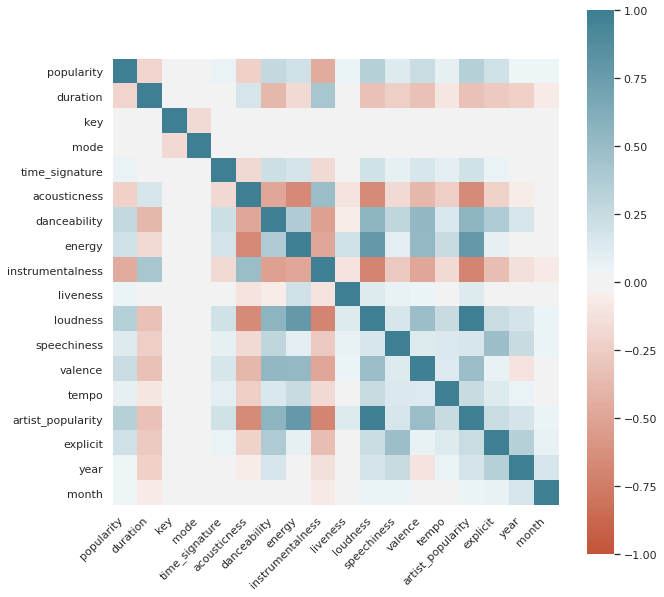

In [21]:

#data = normalized_df
data = visualize_df

corr = data.corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

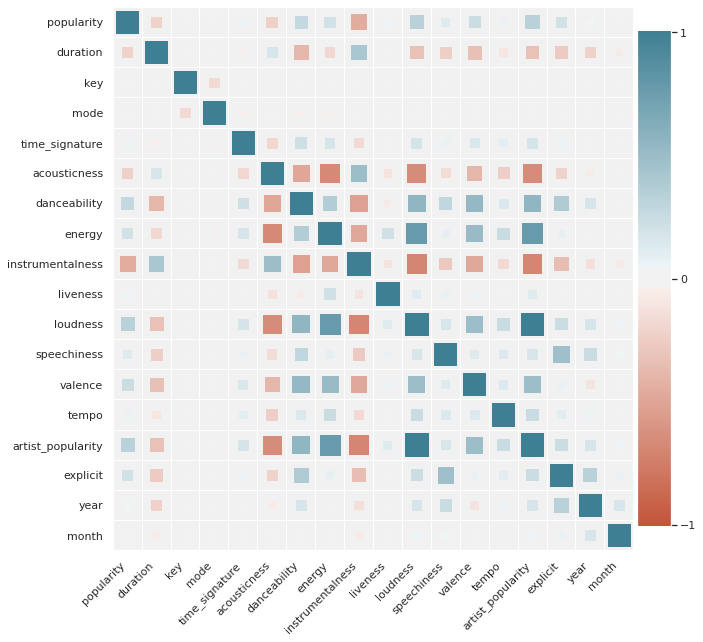

In [22]:
plt.figure(figsize=(10, 10))
corrplot(corr)

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from itertools import combinations

def plot_scatter_3d(x_feature, y_feature):

  x = visualize_df[x_feature]
  y = visualize_df[y_feature]
  z = visualize_df['popularity']

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x, y, z,
            linewidths=1, alpha=.7,
            edgecolor='k',
            s = 200,
            c=z)

  ax.set_xlabel(x_feature)
  ax.set_ylabel(y_feature)
  ax.set_zlabel('popularity')

  plt.show()

list_wo_popularity = DataInformation.list()
list_wo_popularity.remove("popularity")
list_wo_popularity.append("year")
list_wo_popularity.append("month")
list_wo_popularity.append("explicit")
comb_list = []
for comb in combinations(list_wo_popularity, 2):
  comb_list.append(comb)

for pair in comb_list:
  plot_scatter_3d(pair[0], pair[1])


Output hidden; open in https://colab.research.google.com to view.

In [29]:
def plot_predictive_analysis(x):
  y = "popularity"
  dft = visualize_df
  figsize=(10,10)
  ### bin plot
  dtf_noNan = dtf[dtf[x].notnull()]
  breaks = np.quantile(dtf_noNan[x], q=np.linspace(0, 1, 11))
  groups = dtf_noNan.groupby([pd.cut(dtf_noNan[x], bins=breaks, 
            duplicates='drop')])[y].agg(['mean','median','size'])
  fig, ax = plt.subplots(figsize=figsize)
  fig.suptitle(x+"   vs   "+y, fontsize=20)
  groups[["mean", "median"]].plot(kind="line", ax=ax)
  groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                      color="grey", alpha=0.3, grid=True)
  ax.set(ylabel=y)
  ax.right_ax.set_ylabel("Observazions in each bin")
  plt.show()
  ### scatter plot
  sns.jointplot(x=x, y=y, data=dtf, dropna=True, kind='reg', 
                height=int((figsize[0]+figsize[1])/2) )
  plt.show()

list_wo_popularity = DataInformation.list()
list_wo_popularity.remove("popularity")
list_wo_popularity.append("year")
list_wo_popularity.append("month")
list_wo_popularity.append("explicit")

for features in list_wo_popularity:
  plot_predictive_analysis(features)

Output hidden; open in https://colab.research.google.com to view.

# Data Analysis

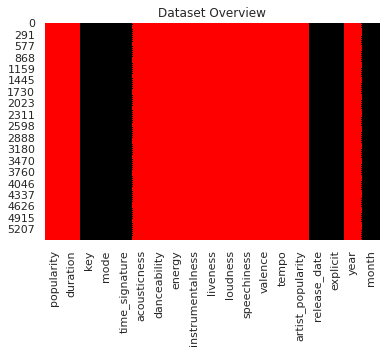

 Categerocial   Numeric   NaN 


In [63]:
'''
Recognize whether a column is numerical or categorical.
'''
from matplotlib import colors
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

cmap = colors.ListedColormap(['black','red'])
dic_cols = {col:utils_recognize_type(visualize_df, col, max_cat=20) for col in visualize_df.columns}
heatmap = visualize_df.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False, cmap=cmap).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

# Split Data: Train, Validation, Train

In [ ]:
def train_validate_test_split(df, train_percent=.7, validate_percent=.15, seed=50):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [ ]:
num_data = normalized_df.shape[0]
num_train = int(num_data*0.7)
num_val = int(num_data*0.15)
num_test = num_data - num_train - num_val

train = SpotifyTracksDataset(normalized_df.iloc[0:num_train])
val = SpotifyTracksDataset(normalized_df.iloc[num_train:num_train+num_val])
test = SpotifyTracksDataset(normalized_df.iloc[num_train+num_val:num_data])


In [ ]:
#train, validate, test = train_validate_test_split(normalized_df)

,duration,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,artist_popularity,popularity
2575,0.055641,0.454545,0.0,0.8,0.650602,0.758865,0.398628,0.000001,0.097007,0.831284,0.181915,0.0859,0.365645,85,72
4151,0.130946,0.000000,0.0,0.6,0.702811,0.092806,0.177122,0.982983,0.269350,0.472427,0.042872,0.0398,0.399769,54,18
3645,0.047170,0.363636,1.0,0.8,0.019275,0.606890,0.888746,0.000001,0.287926,0.908231,0.104681,0.8810,0.780879,78,77
1349,0.032912,0.636364,1.0,0.8,0.761044,0.655522,0.513891,0.000009,0.089783,0.722012,0.044787,0.9550,0.601433,81,60
1653,0.047619,0.545455,0.0,0.8,0.010942,0.918946,0.651204,0.000424,0.088751,0.870699,0.331915,0.6260,0.671723,73,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910,0.021356,0.909091,0.0,0.8,0.106424,0.774063,0.498856,0.000000,0.464396,0.853041,0.469149,0.4230,0.731203,73,24
4822,0.123240,1.000000,0.0,0.8,0.452810,0.547112,0.305415,0.861862,0.088751,0.527794,0.070532,0.1070,0.541354,39,0
1391,0.042004,0.636364,1.0,0.8,0.827309,0.705167,0.463776,0.000000,0.085655,0.806425,0.134043,0.5300,0.371667,92,56
3756,0.046058,0.818182,1.0,0.8,0.093773,0.703141,0.466783,0.000000,0.079463,0.846394,0.040851,0.2460,0.470662,88,37


In [ ]:
class TestNet(nn.Module):
    def __init__(self):
        super(TestNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(14, 50),
            nn.ReLU(),
            nn.Linear(50, 80),
            nn.ReLU(),
            nn.Linear(80, 100),
            nn.ReLU(),
            nn.Linear(100,1),
        ).to(device)
    def forward(self, x):
        x = self.layers(x)
        return x

In [ ]:
net = TestNet()
if torch.cuda.is_available():
  net.cuda()

In [ ]:
def predict_some(model, data, num_to_predict):
  for i in range(0, num_to_predict):
    features, target = data[i]
    features = features.to(device)
    target = target.to(device)

    out = model(features.unsqueeze(0)).clamp(min=0,max=100)
    print(f"Actual: {round(target.item(), 2)};  Predicted: {round(out.item(), 2)}")

In [ ]:
def get_error(model, data):
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)

  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    out = model(features)
    total_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()
  
  average_error = total_error/len(data)
  return average_error

In [ ]:
def train_net(model, train, validate, num_epochs=5, learning_rate=1e-4, bs = 64):
    
    #train_ds = SpotifyTracksDataset(train)
    train_loader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True)

    #val_ds = SpotifyTracksDataset(validate)
    val_loader = torch.utils.data.DataLoader(validate, batch_size=bs, shuffle=True)
    
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    for epoch in range(1, num_epochs + 1):
        epoch_error = 0
        epoch_loss = 0.0
        for i, batch in enumerate(train_loader, 1):
          features, targets = batch

          features = features.to(device)
          targets = targets.to(device)
          
          optimizer.zero_grad()
          out = model(features)
          
          loss = criterion(out, targets)
          loss.backward()
          optimizer.step()


          epoch_loss += loss.item()
          epoch_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()

        epoch_loss = epoch_loss / i
        train_error_rate = epoch_error / len(train)
        val_error_rate = get_error(model, validate)

        train_loss.append(epoch_loss)
        train_acc.append(train_error_rate)
        val_acc.append(val_error_rate)
        iters.append(epoch)
        
        print(f"Epoch {epoch}")
        print(f"  Train Error: {train_error_rate}")
        print(f"  Valid Error: {val_error_rate}")
        print(f"  Train Loss: {epoch_loss}")

        predict_some(model, train, 5)
        predict_some(model, validate, 5)

        print("\n")

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(100 - train_acc[-1]))
    print("Final Validation Accuracy: {}".format(100 - val_acc[-1]))

In [ ]:
'''
def train_net(model, train, validate, num_epochs=5, learning_rate=1e-4, bs = 64):
    
    train_ds = SpotifyTracksDataset(train)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)

    val_ds = SpotifyTracksDataset(validate)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bs, shuffle=True)
    
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    epochs, iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], [], []

    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        error_train = 0
        error_val = 0
        for features, targets in train_loader:
            features = features.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            out = net(features)
            loss = criterion(out, targets)
            loss.backward()
            optimizer.step()
            error_train += (targets - out.clamp(min=0,max=100)).abs().sum().item()

        #save the current training info
        iters.append(n)
        train_loss.append(loss.item())
            

        for features, targets in val_loader:
            optimizer.zero_grad()
            out = net(features)
            loss = criterion(out, targets)
            error_val += (targets - out.clamp(min=0,max=100)).abs().sum().item()

        val_loss.append(loss.item())

        #get accuracy
        train_acc.append(error_train/len(train_ds)) 
        val_acc.append(error_val/len(val_ds))
        n += 1
        print(("Epoch {}: Training Accuracy {} |"+"Validation Accuracy {}").format(epoch, train_acc[epoch], val_acc[epoch]))
        predict_some(model, train_ds, 5)
        predict_some(model, val_ds, 5)
        print("\n")

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

'''

Epoch 1
  Train Error: 20.764174441537836
  Valid Error: 13.313549523214691
  Train Loss: 648.0625872651408
Actual: 76.0;  Predicted: 51.5
Actual: 63.0;  Predicted: 50.36
Actual: 75.0;  Predicted: 47.34
Actual: 29.0;  Predicted: 44.94
Actual: 75.0;  Predicted: 47.72
Actual: 63.0;  Predicted: 48.73
Actual: 56.0;  Predicted: 46.55
Actual: 77.0;  Predicted: 50.37
Actual: 86.0;  Predicted: 53.67
Actual: 76.0;  Predicted: 44.49


Epoch 2
  Train Error: 20.869699704176174
  Valid Error: 13.441787016044543
  Train Loss: 648.4977611194957
Actual: 76.0;  Predicted: 52.17
Actual: 63.0;  Predicted: 51.01
Actual: 75.0;  Predicted: 47.94
Actual: 29.0;  Predicted: 45.51
Actual: 75.0;  Predicted: 48.33
Actual: 63.0;  Predicted: 49.51
Actual: 56.0;  Predicted: 47.14
Actual: 77.0;  Predicted: 51.21
Actual: 86.0;  Predicted: 54.36
Actual: 76.0;  Predicted: 45.12


Epoch 3
  Train Error: 20.82065174237606
  Valid Error: 13.524732423060149
  Train Loss: 652.2551869794357
Actual: 76.0;  Predicted: 51.99
Ac

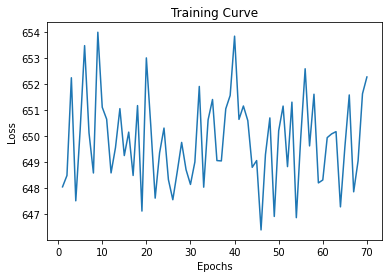

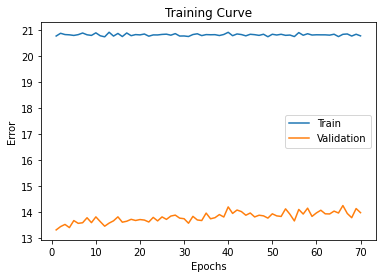

Final Training Accuracy: 79.22977682656905
Final Validation Accuracy: 86.02440509981322


In [ ]:
train_net(net, train, val, 70, 1e-4, 32)

# Baseline Model

# EXPERIMENTING SECTION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
features = ["duration", "key", "mode", "time_signature", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", "tempo"]
training = normalized_df.sample(frac = 0.8,random_state = 420)
# add to code before training SGDRegressor model

X_train = training[features]
y_train = training['popularity']
X_test = normalized_df.drop(training.index)[features]

scaler = StandardScaler()
scaler.fit(X_train)
X_t = scaler.transform(X_train)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_t, y_train, test_size = 0.2, random_state = 420)

In [ ]:
SGD_Model = linear_model.SGDRegressor()
SGD_Model.fit(X_train, y_train)
SGD_Predict = SGD_Model.predict(X_valid)
predict = pd.DataFrame(SGD_Predict)
predict = predict.reset_index(drop=True)
val = pd.DataFrame(y_valid)
val = val.reset_index(drop=True)
compare = pd.concat([predict, val], axis=1)
compare


,0,popularity
0,0.470431,0.80
1,0.478930,0.63
2,0.123215,0.30
3,0.460689,0.03
4,0.478892,0.61
...,...,...
875,0.450532,0.06
876,0.464413,0.63
877,0.489867,0.02
878,0.483063,0.67
